In [ ]:
!pip install transformers
!pip install bert-score
!pip install datasets
!pip install evaluate
!pip install accelerate
!pip install nltk 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import torch
print(torch.cuda.get_device_name(0))
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Tesla V100-SXM2-16GB


In [ ]:
# Set the path to your JSONL file
training_file = "/content/gdrive/MyDrive/cse_635/train.jsonl"
validation_file="/content/gdrive/MyDrive/cse_635/validation.jsonl"

In [ ]:
def getanswers(strs ,position):
    nums=position[0][0]
    start=0
    for i in range(len(strs)):
      if nums==i:
        start+=position[0][1]
        break
      start+=len(strs[i])
    
    return ''.join(strs),start

In [ ]:
import json
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, filepath, type):
        self.data = []
        self.max_length=0
        self.id=0
        with open(filepath, 'r') as f:
            for line in f:
                json_obj = json.loads(line)
                if json_obj['tags'][0]==type:
                    question = json_obj['postText'][0]
                    context = json_obj['targetParagraphs']
                    answer = json_obj['spoiler']
                    strs,start=getanswers(context,json_obj['spoilerPositions'][0])
                    context=strs
                    extracted_data = {
                        'answers': {'answer_start': [start], 'text': answer},
                        'context': context,
                        'question': question,
                        'id':str(self.id),
                    }
                    self.data.append(extracted_data)
                    self.max_length=max(self.max_length,len(context)+len(question[0]))
                self.id+=1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
# Load the dataset using DataLoader
training = MyDataset(training_file,'phrase')
validation = MyDataset(validation_file,'phrase')

In [ ]:
from datasets import Dataset
dset_training = Dataset.from_list(training)
dset_training=dset_training.with_format("torch")

dset_validation = Dataset.from_list(validation)
dset_validation=dset_validation.with_format("torch")

In [ ]:
print(training[10])
print(validation[10])

{'answers': {'answer_start': [591], 'text': ['own personal values']}, 'context': 'Most successful businesses operate by following a fundamental set of core values. Their vision and mission statement reflect these values, the day to day operations are driven by them and they dictate how major decisions are made. Having core values provides a clarity that fosters focus and makes prioritizing easy.As human beings, we all have a personal set of core values that reflect the essence of who we are. We all have them. However having them and consciously allowing them to guide you through life are two entirely different things. Understanding and living a life driven by your own personal values is one of the major keys to success, happiness and inner peace.Write it outThe first step in living a life full of purpose and passion is to write down your own personal values. Your values, though tied to your morals and ethics are not a system of right or wrong. Your personal values are the things you va

In [ ]:
# Combine the 'answers' field from both datasets into a single list
combined_answers = [entry['text'][0] for entry in dset_training["answers"]] + \
                   [entry['text'][0] for entry in dset_validation["answers"]]

# Calculate the maximum length among all answers
max_length = max(len(answer) for answer in combined_answers)

print(max_length)


55


In [ ]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")



In [ ]:
context = dset_training[10]["context"]
question = dset_training[10]["question"]

inputs = tokenizer(
        question,
        context,
        max_length=384,
        truncation="only_second",
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",      
    )

for ids in inputs['input_ids']:
  tokenizer.decode(ids)

inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

The mean of the data is 561.4586686174104
The median of the data is 412.0


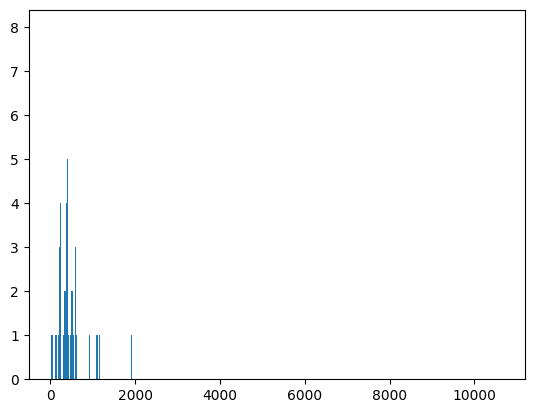

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

# Tokenize the context and questions
inputs = tokenizer(
    dset_training["context"],
    dset_training["question"],
    max_length=500000,  # This is a very large max_length, you might want to reduce it
    truncation="only_second",
    stride=128,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    padding='do_not_pad',      
)

# Compute lengths of each tokenized input
lengths = np.array([len(input_ids) for input_ids in inputs["input_ids"]])

# Calculate mean and median
mean = np.mean(lengths)
median = np.median(lengths)

print(f"The mean of the data is {mean}")
print(f"The median of the data is {median}")

# Count the frequency of each length
length_counts = Counter(lengths)

# Plot histogram
plt.bar(length_counts.keys(), length_counts.values())
plt.show()


In [ ]:
max_length = 384
stride = 128

def preprocess_function_training(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
        
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
tokenized_training = dset_training.map(preprocess_function_training, batched=True,remove_columns=dset_training.column_names)

Map:   0%|          | 0/1367 [00:00<?, ? examples/s]

In [ ]:
def preprocess_function_validation(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids

    offset_mapping = inputs["offset_mapping"]
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions

    return inputs

In [ ]:
tokenized_validation = dset_validation.map(preprocess_function_validation, batched=True,remove_columns=dset_validation.column_names)

Map:   0%|          | 0/335 [00:00<?, ? examples/s]

In [ ]:
from transformers import RobertaForQuestionAnswering

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = RobertaForQuestionAnswering.from_pretrained('roberta-base').to(device)
output_dir="/content/gdrive/MyDrive/cse_635/individual_project/code/baseline/roberta_phrase"


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForQuestionAnswering: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use 

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=5,
    learning_rate = 4e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.001,
    logging_dir=output_dir,
    logging_steps=10,
    save_steps=100,
    save_total_limit=1,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    eval_steps=50,
    disable_tqdm=False,
    fp16=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_training,
    eval_dataset=tokenized_validation,
    tokenizer=tokenizer,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
50,5.721000,5.676229
100,4.456600,4.014772
150,2.460400,2.499993
200,2.052900,1.878452
250,1.852600,1.654095
300,1.446700,1.460385
350,1.313400,1.426085
400,1.835000,1.340351
450,1.161000,1.310182
500,1.703900,1.419966


TrainOutput(global_step=1970, training_loss=1.0224237909625629, metrics={'train_runtime': 369.9025, 'train_samples_per_second': 42.511, 'train_steps_per_second': 5.326, 'total_flos': 3081668624755200.0, 'train_loss': 1.0224237909625629, 'epoch': 5.0})

In [ ]:
import evaluate
from collections import Counter
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction

def my_bleu(hyp_list, ref_list):
    #this weight is used from the paper
    def make_score(trut, predi):
        if len(trut) > 3 and len(predi) > 3:
            weights = (1./4., 1./4., 1./4., 1./4.)
        elif len(trut) > 2 and len(predi) > 2:
            weights = (1./3., 1./3., 1./3.)
        elif len(trut) > 1 and len(predi) > 1:
            weights = (1./2., 1./2.)
        else:
            weights = (1., 0.)

        if (len(weights) == 4) and (len(trut) < 4 or len(predi) < 4):
            print(trut)
            print(predi)
            print(weights)
            print('\n')

        smoothing_fn = SmoothingFunction().method3
        return sentence_bleu([trut], predi, weights=weights, smoothing_function=smoothing_fn)
    
    score=0
    size=len(hyp_list)
    for i in range(size):
      score+=make_score(ref_list[i],hyp_list[i])

    return score/size

def my_meteor(hyp_list, ref_list):
    hyp_tokens_list = [hyp.split() for hyp in hyp_list]
    ref_tokens_list = [ref.split() for ref in ref_list]

    hyp_unigrams = [word for hyp in hyp_tokens_list for word in hyp]
    ref_unigrams = [word for ref in ref_tokens_list for word in ref]
    hyp_unigram_counts = Counter(hyp_unigrams)
    ref_unigram_counts = Counter(ref_unigrams)
    overlap_count = sum((hyp_unigram_counts & ref_unigram_counts).values())

    hyp_count = sum(hyp_unigram_counts.values())
    ref_count = sum(ref_unigram_counts.values())
    precision = overlap_count / hyp_count if hyp_count > 0 else 0
    recall = overlap_count / ref_count if ref_count > 0 else 0

    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return f1_score

bleu = evaluate.load('bleu')
meteor = evaluate.load('meteor')
bertscore = evaluate.load('bertscore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from tqdm.auto import tqdm
import collections
import numpy as np
n_best = 20
max_answer_length = 30

def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)
    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []
        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue
                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)
        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(best_answer["text"])
        else:
            predicted_answers.append("")

    theoretical_answers = [ex["answers"]["text"][0] for ex in examples]
    
    return predicted_answers, theoretical_answers
    


In [ ]:
best_checkpoint = RobertaForQuestionAnswering.from_pretrained("/content/gdrive/MyDrive/cse_635/individual_project/code/baseline/roberta_phrase/checkpoint-1000")
checkpoint_tokenizer=RobertaTokenizerFast.from_pretrained("/content/gdrive/MyDrive/cse_635/individual_project/code/baseline/roberta_phrase/checkpoint-1000")
trainer_best_checkpoint = Trainer(
    model=best_checkpoint,
    args=args,
    train_dataset=tokenized_training,
    eval_dataset=tokenized_validation,
    tokenizer=checkpoint_tokenizer,
)

In [ ]:
predictions, _, _ = trainer_best_checkpoint.predict(tokenized_validation)
start_logits, end_logits = predictions
predicted_answers, theoritical_answers= compute_metrics(start_logits, end_logits, tokenized_validation, dset_validation)
print(predicted_answers[:30])
print(theoritical_answers[:30])


  0%|          | 0/335 [00:00<?, ?it/s]

['20%', 'Sprite', 'Smoky Paprika-Baked Garbanzo Beans', 'Anthony Bourdain', 'naled', 'They don’t fart', 'later start time', 'Re-release a tweaked version of iOS 9.3.2', 'Mike Rounds', 'reduced fat sour cream', 'Edward Gorey', 'Rag & Bone', 'pixie cut', 'southern flying squirrel', 'antique cabinet', 'August 6th', 'huge dick', '"I love you, but ..."', 'The Arizona Republic', 'Isaiah 17:1', 'rapamycin', 'Santa Clara University', 'Oklahoma Wesleyan', 'pricing', 'Tim Masthay', '2,032 pounds', '$13K for another pom in September.$40K', 'University of Tennessee (UT', 'Crazy Frog', 'your face']
['20%', 'Sprite', 'Smoky Paprika-Baked Garbanzo Beans', 'Anthony Bourdain', 'Dibrom', 'They don’t fart', 'starts later', 'bricking iPad Pros', 'Stace Nelson', 'reduced fat sour cream', 'Edward Gorey', 'Rag & Bone', 'pixie cut', 'southern flying squirrel', "Hope's antique cabinet", 'August 6th', 'perfectly average', '"but"', 'The Arizona Republic', 'apocalyptic omen', 'rapamycin', 'Santa Clara University'

In [ ]:
bleu_score1=bleu.compute(predictions=predicted_answers, references=theoritical_answers)
meteor_score1=meteor.compute(predictions=predicted_answers, references=theoritical_answers,gamma=0)
bleu_score2=my_bleu(predicted_answers, theoritical_answers)
meteor_score2 = my_meteor(predicted_answers, theoritical_answers)
bertscore_score=bertscore.compute(predictions=predicted_answers, references=theoritical_answers,lang="en",model_type='roberta-base')
print(bleu_score2)
print(meteor_score1)
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg
print("bert score: "+str(cal_average(bertscore_score['f1'])))

0.6257465914828899
{'meteor': 0.6697663387759408}
bert score: 0.9175006601347853
